# Calibration of the pixel position for a Pilatus detector

This tutorial summarizes the work done by Frederic Sulzman during his internship at ESRF during the summer 2015 entilted "Calibration for geometric distortion in multi-
modules pixel detectors".

The overall strategy is very similar to "CCD calibration" tutorial with some specificities due to the modular nature of the detector.

0. Image preprocessing
1. Peak picking
2. Grid assignment
3. Displacement fitting
4. Reconstruction of the pixel position
5. Saving into a detector definition file

Each module being made by lithographic processes, the error within a module will be assumeed to be constant. We will use the name "displacement of the module" to describe the rigide movement of the module.

This tutorial uses data from the Pilatus3 2M CdTe from the ID15 beam line of the ESRF. 
They provided not only the intersnip subject but also the couple of images uses to calibrate the detector.

This detector contains 48 half-modules, each bound to a single CdTe monocrystal sensor and is designed for high energy X-ray radiation detection. 
Due to the construction procedure, these half-modules could show a misalignment within the detector
plane. 
While the manufacturer (Dectris) garanties a precision within a pixel (172µm), the miss-alignment of certain modules can be seen while calibrating Debye-Scherrer ring using refereance sample. 
So the aim of this work is to provide a detector description with a better precision better than the original detector.

This work will be performed on the image of a grid available:
http://www.silx.org/pub/pyFAI/detector_calibration/Pilatus2MCdTe_ID15_grid_plus_sample_0004.cbf
and the scattering of ceria (CeO2) at 72.1keV available here.
http://www.silx.org/pub/pyFAI/detector_calibration/Pilatus2MCdTe_ID15_CeO2_72100eV_800mm_0000.cbf

It is a good exercise to calibrate all rings of the later image using the *pyFAI-calib2* tool. 
A calibration close to perfection is needed to visualize the module miss-alignement we aim at correcting.

In [1]:
%matplotlib notebook

In [2]:
#many imports which will be used all along the notebook
import time
start_time = time.time()
import os
import pyFAI
import fabio
import glob
import numpy
from math import sin, cos, sqrt
from scipy.ndimage import convolve, binary_dilation
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
from matplotlib.pyplot import subplots
from pyFAI.ext.bilinear import Bilinear
from pyFAI.ext.watershed import InverseWatershed
from silx.resources import ExternalResources

print("Using pyFAI verison: ", pyFAI.version)

Using pyFAI verison:  0.18.0-dev0


In [3]:
#Nota: comment out when running from outside ESRF
os.environ["http_proxy"] = "http://proxy.esrf.fr:3128"

In [4]:
downloader = ExternalResources("detector_calibration", "http://www.silx.org/pub/pyFAI/detector_calibration/")
ring_file = downloader.getfile("Pilatus2MCdTe_ID15_CeO2_72100eV_800mm_0000.cbf")
print(ring_file)
grid_file = downloader.getfile("Pilatus2MCdTe_ID15_grid_plus_sample_0004.cbf")
print(grid_file)

/tmp/detector_calibration_testdata_kieffer/Pilatus2MCdTe_ID15_CeO2_72100eV_800mm_0000.cbf
/tmp/detector_calibration_testdata_kieffer/Pilatus2MCdTe_ID15_grid_plus_sample_0004.cbf


<IPython.core.display.Javascript object>


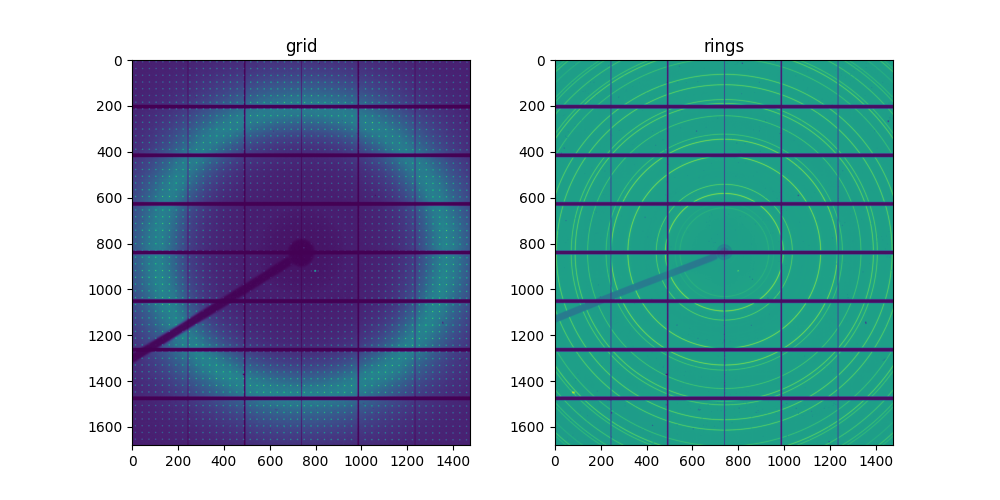

Text(0.5, 1.0, 'rings')

In [5]:
rings = fabio.open(ring_file).data
img = fabio.open(grid_file).data
fig,ax = subplots(1,2, figsize=(10,5))
ax[0].imshow(img.clip(0,1000), interpolation="bilinear")
ax[0].set_title("grid")
ax[1].imshow(numpy.arcsinh(rings), interpolation="bilinear")
ax[1].set_title("rings")

## Image processing

There are 3 pre-processing steps which are needed.

1. Define for each module a unique identifier which will be used later on during the fitting procedure
2. Define the proper mask: each module is the assembly of 4x2 sub-modules and there are (3) interpolated pixels between each sub-module, such "unreliable pixels should be masked out as well
3. Correct the grid image by the smoothed image to have a constant background.
4. Convolve the raw image with a typical hole shape to allow a precise spotting of the hole center.


In [6]:
# This is the default detector as definied in pyFAI according to the specification provided by Dectris:
pilatus = pyFAI.detector_factory("Pilatus_2m_CdTe")
print(pilatus)

mask1 = pilatus.mask
module_size = pilatus.MODULE_SIZE
module_gap = pilatus.MODULE_GAP
submodule_size = (96,60)

Detector Pilatus CdTe 2M	 PixelSize= 1.720e-04, 1.720e-04 m


In [7]:
#1 + 2 Calculation of the module_id and the interpolated-mask:
mid = numpy.zeros(pilatus.shape, dtype=int)
mask2 = numpy.zeros(pilatus.shape, dtype=int)
idx = 1
for i in range(8):
    y_start = i*(module_gap[0] + module_size[0])
    y_stop = y_start + module_size[0]
    for j in range(3):
        x_start = j*(module_gap[1] + module_size[1])
        x_stop = x_start + module_size[1]
        mid[y_start:y_stop,x_start: x_start+module_size[1]//2] = idx
        idx+=1
        mid[y_start:y_stop,x_start+module_size[1]//2: x_stop] = idx
        idx+=1
        mask2[y_start+submodule_size[0]-1:y_start+submodule_size[0]+2,
              x_start:x_stop] = 1
        for k in range(1,8):
            mask2[y_start:y_stop,
              x_start+k*(submodule_size[1]+1)-1:x_start+k*(submodule_size[1]+1)+2] = 1

In [8]:
#Extra masking
mask0 = img<0
#Those pixel are miss-behaving... they are the hot islet next to the beam-stop
mask0[915:922,793:800] = 1
mask0[817:820,747:750] = 1

<IPython.core.display.Javascript object>


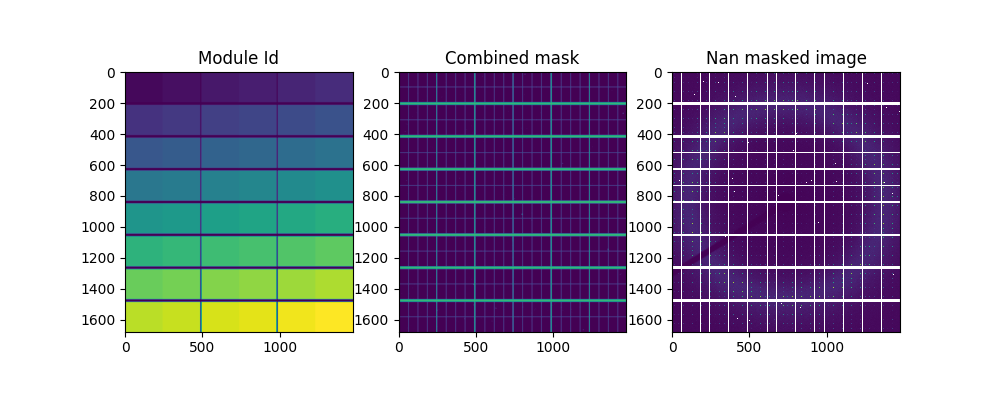

Text(0.5, 1.0, 'Nan masked image')

In [9]:
fig,ax = subplots(1,3, figsize=(10,4))
ax[0].imshow(mid, interpolation="bilinear")
ax[0].set_title("Module Id")

ax[1].imshow(mask2+mask1+mask0, interpolation="bilinear")
ax[1].set_title("Combined mask")

nimg = img.astype(float)
nimg[numpy.where(mask0+mask1+mask2)] = numpy.nan


ax[2].imshow(nimg)#, interpolation="bilinear")
ax[2].set_title("Nan masked image")

In [10]:
# The Nan-masked image contains now only valid values (and Nan elsewhere). We will make a large median filter to 
# build up a smooth image without gaps.
#
# This function is backported from future version of numpy ... it allows to expose a winbowed view 
# to perform the nanmedian-filter
from numpy.lib.stride_tricks import as_strided
def sliding_window_view(x, shape, subok=False, readonly=True):
    """
    Creates sliding window views of the N dimensional array with the given window
    shape. Window slides across each dimension of `x` and extract subsets of `x`
    at any window position.
    Parameters
    ----------
    x : array_like
        Array to create sliding window views of.
    shape : sequence of int
        The shape of the window. Must have same length as the number of input array dimensions.
    subok : bool, optional
        If True, then sub-classes will be passed-through, otherwise the returned
        array will be forced to be a base-class array (default).
    readonly : bool, optional
        If set to True, the returned array will always be readonly view.
        Otherwise it will return writable copies(see Notes).
    Returns
    -------
    view : ndarray
        Sliding window views (or copies) of `x`. view.shape = x.shape - shape + 1
    See also
    --------
    as_strided: Create a view into the array with the given shape and strides.
    broadcast_to: broadcast an array to a given shape.
    Notes
    -----
    ``sliding_window_view`` create sliding window views of the N dimensions array
    with the given window shape and its implementation based on ``as_strided``.
    Please note that if readonly set to True, views are returned, not copies
    of array. In this case, write operations could be unpredictable, so the returned
    views are readonly. Bear in mind that returned copies (readonly=False) will
    take more memory than the original array, due to overlapping windows.
    For some cases there may be more efficient approaches to calculate transformations
    across multi-dimensional arrays, for instance `scipy.signal.fftconvolve`, where combining
    the iterating step with the calculation itself while storing partial results can result
    in significant speedups.
    Examples
    --------
    >>> i, j = np.ogrid[:3,:4]
    >>> x = 10*i + j
    >>> shape = (2,2)
    >>> np.lib.stride_tricks.sliding_window_view(x, shape)
    array([[[[ 0,  1],
             [10, 11]],
            [[ 1,  2],
             [11, 12]],
            [[ 2,  3],
             [12, 13]]],
           [[[10, 11],
             [20, 21]],
            [[11, 12],
             [21, 22]],
            [[12, 13],
             [22, 23]]]])
    """
    np = numpy
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    try:
        shape = np.array(shape, np.int)
    except:
        raise TypeError('`shape` must be a sequence of integer')
    else:
        if shape.ndim > 1:
            raise ValueError('`shape` must be one-dimensional sequence of integer')
        if len(x.shape) != len(shape):
            raise ValueError("`shape` length doesn't match with input array dimensions")
        if np.any(shape <= 0):
            raise ValueError('`shape` cannot contain non-positive value')

    o = np.array(x.shape) - shape  + 1 # output shape
    if np.any(o <= 0):
        raise ValueError('window shape cannot larger than input array shape')

    if type(readonly) != bool:
        raise TypeError('readonly must be a boolean')

    strides = x.strides
    view_strides = strides

    view_shape = np.concatenate((o, shape), axis=0)
    view_strides = np.concatenate((view_strides, strides), axis=0)
    view = as_strided(x, view_shape, view_strides, subok=subok, writeable=not readonly)

    if not readonly:
        return view.copy()
    else:
        return view

(1679, 1475)
(1697, 1485)
(1679, 1475)


<IPython.core.display.Javascript object>


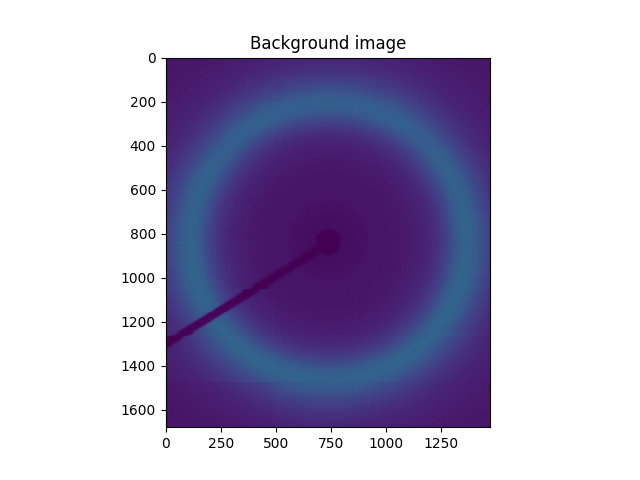

CPU times: user 22.5 s, sys: 1.72 s, total: 24.2 s
Wall time: 24.2 s


In [11]:
%%time 
#Calculate a background image using a large median filter ... takes a while
shape = (19,11)
print(nimg.shape)
padded = numpy.pad(nimg, tuple((i//2,) for i in shape), mode="edge")
print(padded.shape)
background = numpy.nanmedian(sliding_window_view(padded,shape), axis = (-2,-1))
print(background.shape)
fig,ax = subplots()
ax.imshow(background)
ax.set_title("Background image")

<IPython.core.display.Javascript object>


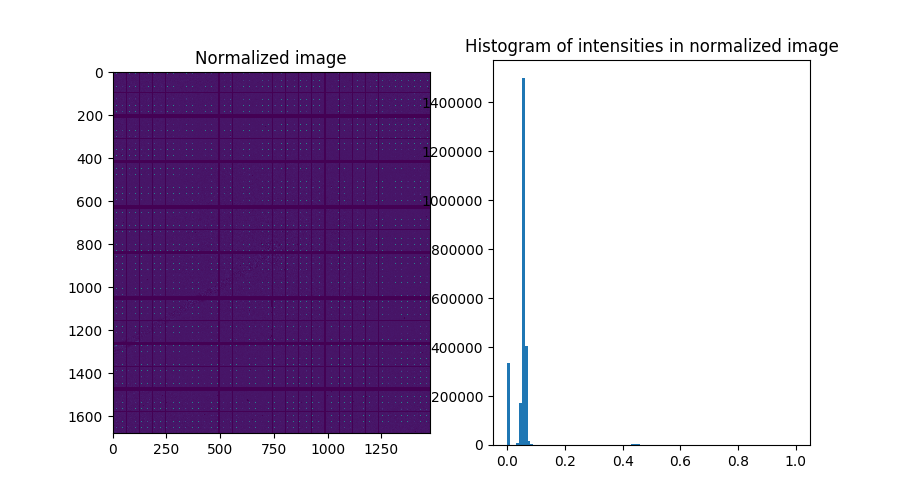

0.0 17.728813559322035


Text(0.5, 1.0, 'Histogram of intensities in normalized image')

In [12]:
fig,ax = subplots(1,2, figsize=(9,5))

normalized = (nimg/background)

low = numpy.nanmin(normalized)
high = numpy.nanmax(normalized)
print(low, high)
normalized[numpy.isnan(normalized)] = 0
normalized /= high

ax[0].imshow(normalized)
ax[0].set_title("Normalized image")

ax[1].hist(normalized.ravel(), 100, range=(0,1))
ax[1].set_title("Histogram of intensities in normalized image")

For a precise measurement of the peak position, one trick is to convolve the image with a pattern which looks like a hole of the grid.


<IPython.core.display.Javascript object>


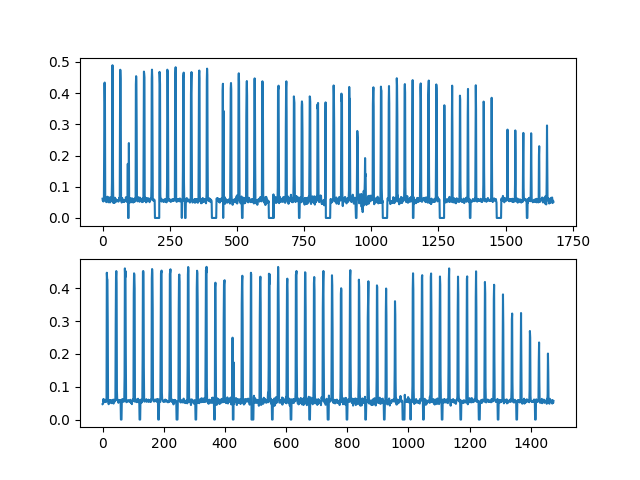

In [13]:
#print the profile of the normalized image: the center is difficult to measure due to the small size of the hole.
fig,ax = subplots(2)
ax[0].plot(normalized[:,545])
ax[1].plot(normalized[536,:])

19.63857792789662


<IPython.core.display.Javascript object>


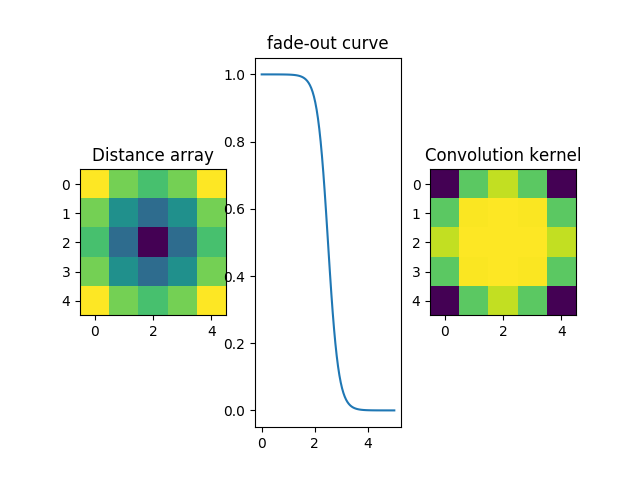

Text(0.5, 1.0, 'Convolution kernel')

In [14]:
#Definition of the convolution kernel
ksize = 5
y,x = numpy.ogrid[-(ksize-1)//2:ksize//2+1,-(ksize-1)//2:ksize//2+1]
d = numpy.sqrt(y*y+x*x)

#Fade out curve definition
fadeout = lambda x: 1/(1+numpy.exp(5*(x-2.5)))

kernel = fadeout(d)
mini=kernel.sum()
print(mini)

fig,ax = subplots(1,3)
ax[0].imshow(d)
ax[0].set_title("Distance array")

ax[1].plot(numpy.linspace(0,5,100),fadeout(numpy.linspace(0,5,100)))
ax[1].set_title("fade-out curve")

ax[2].imshow(kernel)
ax[2].set_title("Convolution kernel")


(1679, 1475)


<IPython.core.display.Javascript object>


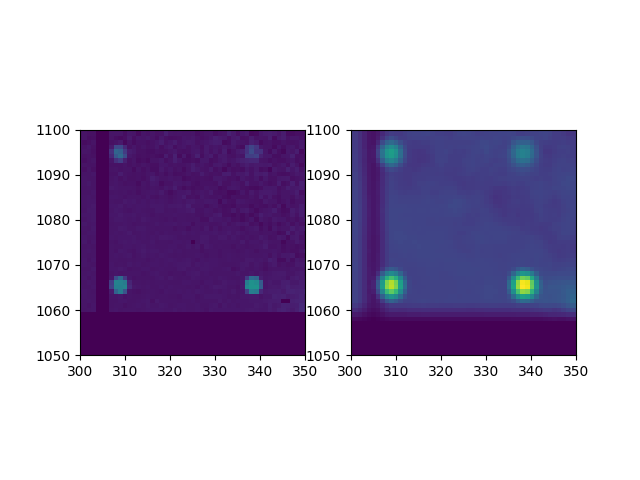

(array([1065]), array([338]))

In [15]:
my_smooth = convolve(normalized, kernel, mode="constant", cval=0)/mini
print(my_smooth.shape)
fig,ax = subplots(1,2)
ax[0].imshow(normalized.clip(0,1))
ax[0].set_ylim(1050,1100)
ax[0].set_xlim(300,350)
ax[1].imshow(my_smooth.clip(0,1))
ax[1].set_ylim(1050,1100)
ax[1].set_xlim(300,350)
numpy.where(my_smooth == my_smooth.max())

335009
782371


<IPython.core.display.Javascript object>


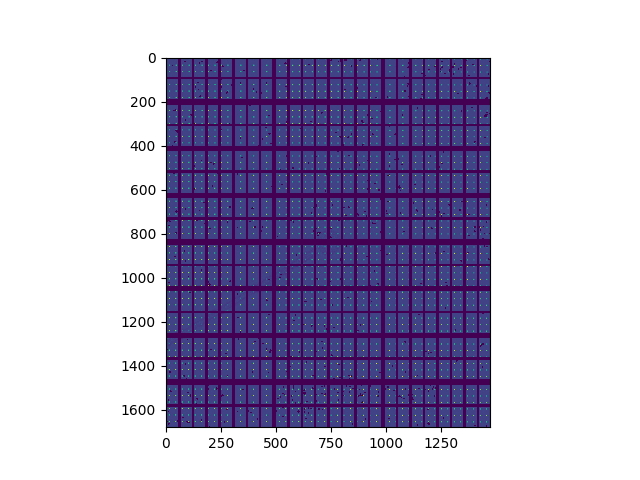

In [16]:
#mask out all pixels too close to any masked position

all_masks = numpy.logical_or(numpy.logical_or(mask0,mask1),mask2)
print(all_masks.sum())
big_mask = binary_dilation(all_masks, iterations=ksize//2+1+1)
print(big_mask.sum())
smooth2 = my_smooth.copy()
smooth2[big_mask] = 0
fig,ax = subplots()
ax.imshow(smooth2)

<IPython.core.display.Javascript object>


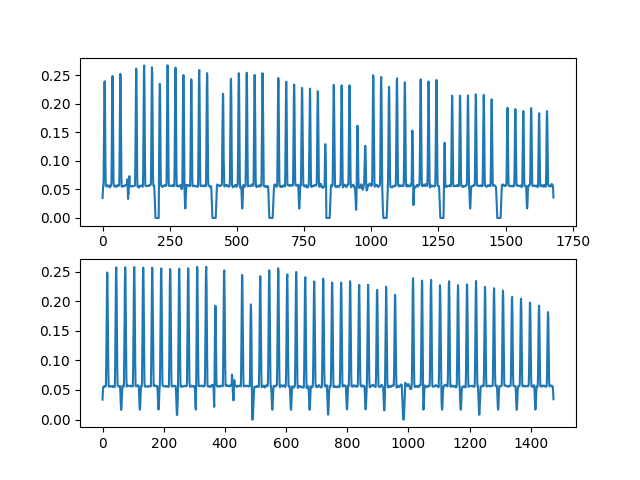

In [17]:
#Display the profile of the smoothed image: the center is easy to measure thanks to the smoothness of the signal
fig,ax = subplots(2)
ax[0].plot(my_smooth[:,545])
ax[1].plot(my_smooth[536,:])

## Peak picking

We use the watershed module from *pyFAI* to retrieve all peak positions.
Those regions are sieved out respectively for:

* their size, it should be larger than the kernel itself
* the peaks too close to masked regions are removed
* the intensity of the peak



In [18]:
iw = InverseWatershed(my_smooth)
iw.init()
iw.merge_singleton()
all_regions = set(iw.regions.values())

regions = [i for i in all_regions if i.size>mini]

print("Number of region segmented: %s"%len(all_regions))
print("Number of large enough regions : %s"%len(regions))


Number of region segmented: 82126
Number of large enough regions : 41333


In [19]:
#Remove peaks on masked region
sieved_region = [i for i in regions if not big_mask[(i.index//nimg.shape[-1], i.index%nimg.shape[-1])]]
print("Number of peaks not on masked areea : %s"%len(sieved_region))

Number of peaks not on masked areea : 30001


<IPython.core.display.Javascript object>


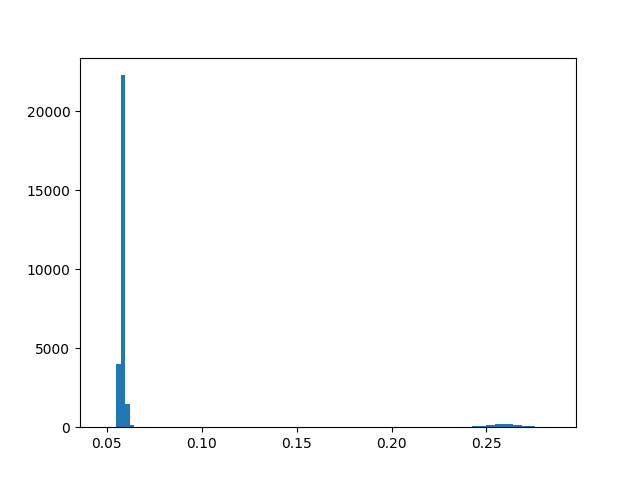

(array([1.0000e+00, 0.0000e+00, 1.0000e+01, 3.9940e+03, 2.2274e+04,
        1.4800e+03, 1.1700e+02, 3.4000e+01, 8.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 3.00

In [20]:
# Histogram of peak height:
s = numpy.array([i.maxi for i in sieved_region])

fig, ax = subplots()
ax.hist(s, 100)

In [21]:
#sieve-out for peak intensity
int_mini = 0.1
peaks = [(i.index//nimg.shape[-1], i.index%nimg.shape[-1]) for i in sieved_region if (i.maxi)>int_mini]
print("Number of remaining peaks with I>%s: %s"%(int_mini, len(peaks)))

peaks_raw = numpy.array(peaks)

Number of remaining peaks with I>0.1: 2075


<IPython.core.display.Javascript object>


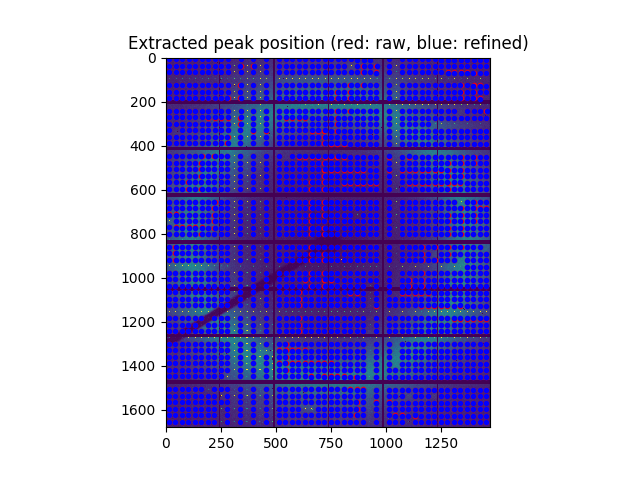

Refined peak coordinate:
[(712.3509621024132, 15.442198574543), (917.9292084947228, 14.754244700074196), (918.0213371720165, 44.29066410660744), (918.0232976004481, 73.55216008424759), (918.1469706445932, 103.11248800903559), (918.1079366579652, 132.52069121599197), (183.4998989701271, 16.392478436231613), (918.2937975525856, 161.87057591974735), (918.2959905266762, 191.31305387616158), (183.50560438632965, 45.46551960706711)]


In [22]:
# Finally the peak positions are interpolated using a second order taylor expansion 
# in thevinicy of the maximum value of the signal:

#Create bilinear interpolator
bl = Bilinear(my_smooth)

#Overlay raw peak coordinate and refined peak positions

ref_peaks = [bl.local_maxi(p) for p in peaks]
fig, ax = subplots()
ax.imshow(img.clip(0,1000), interpolation="nearest")
peaks_ref = numpy.array(ref_peaks)
ax.plot(peaks_raw[:,1], peaks_raw[:, 0], ".r")
ax.plot(peaks_ref[:,1],peaks_ref[:, 0], ".b")
ax.set_title("Extracted peak position (red: raw, blue: refined)")
print("Refined peak coordinate:")
print(ref_peaks[:10])


At this stage we have about 2000 peaks (with sub-pixel precision) which are visually distributed on all modules.
Some modules have their peaks located along sub-module boundaries which are masked out, hence they have fewer ontrol point for the calculation.
Let's assign each peak to a module identifier. This allows to print out the number of peaks per module:

In [23]:
dt = numpy.dtype([('y', numpy.float64),
                  ('x', numpy.float64),
                  ('i', numpy.int64),
                 ])
yxi = numpy.array([i+(mid[round(i[0]),round(i[1])],) 
                   for i in ref_peaks], dtype=dt)
print("Number of keypoint per module:")
for i in range(1,mid.max()+1):
    print("Module id:",i, "cp:", (yxi[:]["i"] == i).sum())

Number of keypoint per module:
Module id: 1 cp: 48
Module id: 2 cp: 30
Module id: 3 cp: 48
Module id: 4 cp: 46
Module id: 5 cp: 42
Module id: 6 cp: 47
Module id: 7 cp: 47
Module id: 8 cp: 30
Module id: 9 cp: 48
Module id: 10 cp: 48
Module id: 11 cp: 41
Module id: 12 cp: 39
Module id: 13 cp: 48
Module id: 14 cp: 30
Module id: 15 cp: 47
Module id: 16 cp: 48
Module id: 17 cp: 42
Module id: 18 cp: 48
Module id: 19 cp: 47
Module id: 20 cp: 30
Module id: 21 cp: 48
Module id: 22 cp: 47
Module id: 23 cp: 42
Module id: 24 cp: 47
Module id: 25 cp: 48
Module id: 26 cp: 30
Module id: 27 cp: 48
Module id: 28 cp: 47
Module id: 29 cp: 41
Module id: 30 cp: 50
Module id: 31 cp: 46
Module id: 32 cp: 30
Module id: 33 cp: 48
Module id: 34 cp: 42
Module id: 35 cp: 47
Module id: 36 cp: 48
Module id: 37 cp: 48
Module id: 38 cp: 28
Module id: 39 cp: 48
Module id: 40 cp: 42
Module id: 41 cp: 44
Module id: 42 cp: 48
Module id: 43 cp: 47
Module id: 44 cp: 26
Module id: 45 cp: 46
Module id: 46 cp: 42
Module id: 4

## Grid assignment

The calibration is performed using a regular grid, the idea is to assign to each peak of coordinates (x,y) the integer value (X, Y) which correspond to the grid corrdinate system. 

The first step is to measure the grid pitch which correspond to the distance (in pixels) from one peak to the next. This is easily obtained from a pair-wise distribution function.

<IPython.core.display.Javascript object>


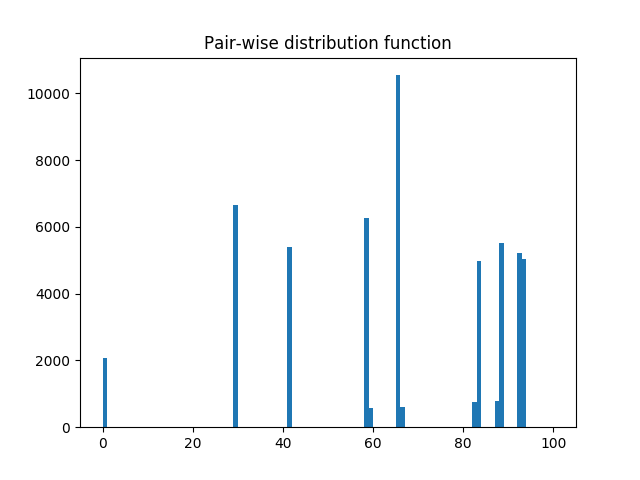

Text(0.5, 1.0, 'Pair-wise distribution function')

In [24]:
# pairwise distance calculation using scipy.spatial.distance_matrix

dist = distance_matrix(peaks_ref, peaks_ref)

fig, ax = subplots()
ax.hist(dist.ravel(), 100, range=(0,100))
ax.set_title("Pair-wise distribution function")

The histogram of the pair-distribution function has a first peak at 0 and the second peak between 29 and 30. 
Let's start the fit with this value

Two other parameters correspond to the offset, in pixel for the grid index (X,Y) = (0,0). 
The easiest is to measure the smallest *x* and *y* for the first module.

In [25]:
#from pair-wise distribution histogram
step = 29 
#work with the first module and fit the peak positions
first = yxi[yxi[:]["i"] == 1]
y_min = first[:]["y"].min()
x_min = first[:]["x"].min()
print("offset for the first peak: ", x_min, y_min)

offset for the first peak:  16.269793540239334 7.186804354190826


The grid looks very well aligned with the axes which makes this step easier but nothing garanties it is perfect, so the rotation of the grid has to be measured as well.

The default rotation will be zero and will be fitted later on.

Once the indexes *X,Y* determined for eack peak, one can fit the parameter to properly align the grid with the first module. Those 4 parameters are *step-size, x_min, y_min* and *angle*

In [26]:
#Assign each peak to an index
dl = numpy.dtype([('y', numpy.float64),
                  ('x', numpy.float64),
                  ('i', numpy.int64),
                  ('Y', numpy.int64),
                  ('X', numpy.int64),
                 ])
indexed1 = numpy.zeros(len(first), dtype=dl)

for i,v in enumerate(first):
    Y = int(round((v["y"]-y_min)/step))
    X = int(round((v["x"]-x_min)/step))
    indexed1[i]["y"] = v["y"]
    indexed1[i]["x"] = v["x"]
    indexed1[i]["i"] = v["i"]
    indexed1[i]["Y"] = Y
    indexed1[i]["X"] = X
    print("peak id: %s %20s Y:%d (Δ=%.3f) X:%s (Δ=%.3f)"%
          (i,v, Y, (v["y"]-Y*step-y_min)/step, X, (v["x"]-X*step-x_min)/step))


peak id: 0 (183.49989897, 16.39247844, 1) Y:6 (Δ=0.080) X:0 (Δ=0.004)
peak id: 1 (183.50560439, 45.46551961, 1) Y:6 (Δ=0.080) X:1 (Δ=0.007)
peak id: 2 (183.60742423, 75.08415242, 1) Y:6 (Δ=0.083) X:2 (Δ=0.028)
peak id: 3 (183.51583004, 104.62201929, 1) Y:6 (Δ=0.080) X:3 (Δ=0.047)
peak id: 4 (183.66220078, 133.73585817, 1) Y:6 (Δ=0.085) X:4 (Δ=0.051)
peak id: 5 (183.65553248, 163.30831155, 1) Y:6 (Δ=0.085) X:5 (Δ=0.070)
peak id: 6 (183.60811904, 192.46339762, 1) Y:6 (Δ=0.083) X:6 (Δ=0.076)
peak id: 7 (183.75545964, 222.06266521, 1) Y:6 (Δ=0.089) X:7 (Δ=0.096)
peak id: 8 (65.94893547, 16.45467511, 1) Y:2 (Δ=0.026) X:0 (Δ=0.006)
peak id: 9 (65.94483702, 45.61336857, 1) Y:2 (Δ=0.026) X:1 (Δ=0.012)
peak id: 10 (66.03506869, 75.15414216, 1) Y:2 (Δ=0.029) X:2 (Δ=0.030)
peak id: 11 (65.89957739, 104.38019937, 1) Y:2 (Δ=0.025) X:3 (Δ=0.038)
peak id: 12 (66.12287057, 133.89461011, 1) Y:2 (Δ=0.032) X:4 (Δ=0.056)
peak id: 13 (66.1012452, 163.39174998, 1) Y:2 (Δ=0.032) X:5 (Δ=0.073)
peak id: 14 (66

The error in positionning each of the pixel is less than 0.1 pixel which is already excellent and will allow a straight forward fit.

The cost function for the first module is calculated as the sum of distances squared in pixel space.
It uses 4 parameters which are step-size, x_min, y_min and angle

In [27]:
guess1 = [step, y_min, x_min, 0]

def cost1(param):
    """contains: step, y_min, x_min, angle for the first module
    returns the sum of distance squared in pixel space
    """
    step = param[0]
    y_min = param[1]
    x_min = param[2]
    angle = param[3]
    XY = numpy.vstack((indexed1["X"], indexed1["Y"]))
    rot = [[cos(angle),-sin(angle)],
           [sin(angle), cos(angle)]]
    xy_min = [[x_min], [y_min]]
    xy_guess = numpy.dot(rot, step*XY+xy_min)
    delta = xy_guess - numpy.vstack((indexed1["x"], indexed1["y"]))
    return (delta*delta).sum()

In [28]:
print("Before optimization", guess1, "cost=", cost1(guess1))
res1 = minimize(cost1, guess1, method = "slsqp")
print(res1)
print("After optimization", res1.x, "cost=", cost1(res1.x))
print("Average displacement (pixels): ",sqrt(cost1(res1.x)/len(indexed1)))

Before optimization [29, 7.186804354190826, 16.269793540239334, 0] cost= 250.3671082603823
     fun: 0.6337542146618408
     jac: array([ 2.14286149e-04, -1.17769092e-03,  1.05167180e-03, -3.24658319e-01])
 message: 'Optimization terminated successfully.'
    nfev: 51
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([2.93980817e+01, 7.13605738e+00, 1.63978976e+01, 8.76803686e-04])
After optimization [2.93980817e+01 7.13605738e+00 1.63978976e+01 8.76803686e-04] cost= 0.6337542146618408
Average displacement (pixels):  0.114905234021149


At this step, the grid is perfectly aligned with the first module. 
This module is used as the reference one and all other are aligned along it, using this first fit:

In [29]:
#retrieve the result of the first module fit:
step, y_min, x_min, angle = res1.x
indexed = numpy.zeros(yxi.shape, dtype=dl)

rot =  [[cos(angle),-sin(angle)],
        [sin(angle), cos(angle)]]
irot =  [[cos(angle), sin(angle)],
         [-sin(angle), cos(angle)]]

print("cost1: ",cost1([step, y_min, x_min, angle]), "for:", step, y_min, x_min, angle)

xy_min = numpy.array([[x_min], [y_min]])
xy = numpy.vstack((yxi["x"], yxi["y"]))
indexed["y"] = yxi["y"]
indexed["x"] = yxi["x"]
indexed["i"] = yxi["i"]
XY_app = (numpy.dot(irot, xy)-xy_min) / step
XY_int = numpy.round((XY_app)).astype("int")
indexed["X"] = XY_int[0]
indexed["Y"] = XY_int[1]
xy_guess = numpy.dot(rot, step * XY_int + xy_min)

thres = 1.2
delta = abs(xy_guess - xy)
print((delta>thres).sum())
suspicious = indexed[numpy.where(abs(delta>thres))[1]]
print(suspicious)

cost1:  0.6337542146618408 for: 29.39808169130698 7.136057379015778 16.397897625618825 0.0008768036855854291
6
[(1624.68617365, 807.47743243, 46, 55, 27)
 (1448.66381988, 895.86545633, 40, 49, 30)
 (1448.84506877, 954.56920397, 40, 49, 32)
 (1595.5792897 , 954.49445057, 46, 54, 32)
 (1448.30209509, 748.8784325 , 40, 49, 25)
 (1654.4202804 , 954.44135761, 46, 56, 32)]


<IPython.core.display.Javascript object>


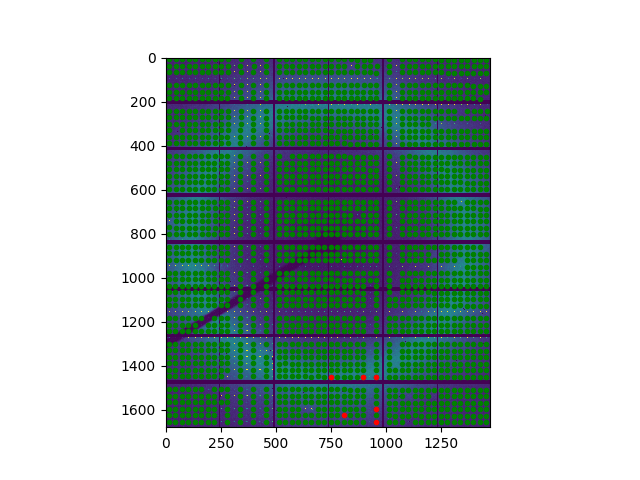

In [30]:
fig,ax = subplots()
ax.imshow(img.clip(0,1000))
ax.plot(indexed["x"], indexed["y"],".g")
ax.plot(suspicious["x"], suspicious["y"],".r")

Only 6 peaks have an initial displacement of more than 1.2 pixel, all located in modules 40 and 46. 
The visual inspection confirms their localization is valid.

There are 48 (half-)modules which have each of them 2 translations and one rotation. 
In addition to the step size, this represents 145 degrees of freedom for the fit.
The first module is used to align the grid, all other modules are then aligned along this grid.

In [31]:
def submodule_cost(param, module=1):
    """contains: step, y_min_1, x_min_1, angle_1, y_min_2, x_min_2, angle_2, ...
    returns the sum of distance squared in pixel space
    """
    
    step = param[0]
    y_min1 = param[1]
    x_min1 = param[2]
    angle1 = param[3]
    
    mask = indexed["i"] == module
    substack = indexed[mask]
    
    XY = numpy.vstack((substack["X"], substack["Y"]))
    rot1 = [[cos(angle1), -sin(angle1)],
            [sin(angle1), cos(angle1)]]
    xy_min1 = numpy.array([[x_min1], [y_min1]])
    xy_guess1 = numpy.dot(rot1, step * XY + xy_min1)
    #This is guessed spot position for module #1
    if module == 1:
        "Not much to do for module 1"
        delta = xy_guess1 - numpy.vstack((substack["x"], substack["y"]))
    else:
        "perform the correction for given module"
        y_min = param[(module-1)*3+1]
        x_min = param[(module-1)*3+2]
        angle = param[(module-1)*3+3]     

        rot = numpy.array([[cos(angle),-sin(angle)],
                           [sin(angle), cos(angle)]])
        xy_min = numpy.array([[x_min], [y_min]])
        xy_guess = numpy.dot(rot, xy_guess1+xy_min)
        delta = xy_guess - numpy.vstack((substack["x"], substack["y"]))

    return (delta*delta).sum()

guess145 = numpy.zeros(48*3+1)
guess145[:4] = res1.x
for i in range(1, 49):
    print("Cost for module #",i, submodule_cost(guess145, i))


Cost for module # 1 0.6337542146618408
Cost for module # 2 1.8137341579499637
Cost for module # 3 1.8517790206873288
Cost for module # 4 4.912782430163363
Cost for module # 5 1.7737133213476264
Cost for module # 6 7.486928782641679
Cost for module # 7 14.439347434483945
Cost for module # 8 5.2192416370218915
Cost for module # 9 23.40369013435511
Cost for module # 10 5.6892016443894615
Cost for module # 11 4.128377014485792
Cost for module # 12 8.414683997256157
Cost for module # 13 29.862711709296487
Cost for module # 14 12.62946959065813
Cost for module # 15 3.1375753663046826
Cost for module # 16 5.280064037657154
Cost for module # 17 8.497445902330067
Cost for module # 18 4.655799399207647
Cost for module # 19 6.008512919062659
Cost for module # 20 4.982309231449203
Cost for module # 21 5.137219625523127
Cost for module # 22 5.050518598053747
Cost for module # 23 1.4370019271696184
Cost for module # 24 6.050451233927471
Cost for module # 25 38.262612956361764
Cost for module # 26 19

On retrieves that the modules 40 and 46 have large errors. Module 37 as well.

The total cost funtion is hence the sum of all cost function for all modules:

In [32]:
def total_cost(param):
    """contains: step, y_min_1, x_min_1, angle_1, ...
    returns the sum of distance squared in pixel space
    """
    return sum(submodule_cost(param, module=i) for i in range(1,49))
total_cost(guess145)

778.6684835866992

In [33]:
%%time
print("Before optimization", guess145[:10], "cost=", total_cost(guess145))
res_all = minimize(total_cost, guess145, method = "slsqp")
print(res_all)
print("After optimization", res_all.x[:10], "cost=", total_cost(res_all.x))

Before optimization [2.93980817e+01 7.13605738e+00 1.63978976e+01 8.76803686e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00] cost= 778.6684835866992
     fun: 27.183659003763143
     jac: array([ 3.43784332e-01,  4.11510468e-04,  1.05545521e-02, -8.25525904e+00,
       -2.92301178e-04, -8.75234604e-04, -1.13747120e-02, -2.33650208e-05,
       -8.41617584e-05, -1.65624619e-02, -5.74588776e-05, -2.61068344e-04,
       -8.79025459e-03,  1.00135803e-05,  3.70979309e-04, -6.46841526e-02,
       -2.29120255e-04,  1.47533417e-03, -1.67098284e-01,  1.97339058e-03,
        8.63313675e-04, -3.68912220e-02,  1.47247314e-03,  1.97434425e-03,
       -2.91111469e-02, -4.53710556e-04, -1.88827515e-04, -1.38798475e-01,
       -2.48908997e-04,  4.37974930e-04, -1.00244761e-01,  7.10487366e-05,
       -3.38792801e-04, -4.47788239e-02, -1.00374222e-04, -1.19447708e-04,
       -3.10077667e-02,  2.84194946e-04,  3.55958939e-04, -1.04611635e-01,
       -7.445

In [34]:
for i in range(1,49):
    print("Module id: %d cost: %.3f Δx: %.3f, Δy: %.3f rot: %.3f°"%
          (i, submodule_cost(res_all.x, i), res_all.x[-2+i*3], res_all.x[-1+i*3], numpy.rad2deg(res_all.x[i*3])))

Module id: 1 cost: 0.683 Δx: 7.106, Δy: 16.362 rot: 0.050°
Module id: 2 cost: 0.473 Δx: -0.261, Δy: -0.172 rot: 0.016°
Module id: 3 cost: 0.650 Δx: -0.465, Δy: -0.149 rot: 0.053°
Module id: 4 cost: 0.613 Δx: -1.409, Δy: -0.039 rot: 0.111°
Module id: 5 cost: 0.566 Δx: -0.472, Δy: -0.435 rot: 0.018°
Module id: 6 cost: 0.666 Δx: -2.558, Δy: -0.442 rot: 0.119°
Module id: 7 cost: 0.696 Δx: -0.762, Δy: 0.501 rot: 0.077°
Module id: 8 cost: 0.341 Δx: -0.836, Δy: 0.211 rot: 0.062°
Module id: 9 cost: 0.566 Δx: -1.273, Δy: -0.128 rot: 0.051°
Module id: 10 cost: 0.661 Δx: -2.053, Δy: 0.205 rot: 0.121°
Module id: 11 cost: 0.616 Δx: -0.329, Δy: -0.112 rot: 0.027°
Module id: 12 cost: 0.495 Δx: -0.588, Δy: 0.037 rot: 0.037°
Module id: 13 cost: 0.763 Δx: -0.824, Δy: 0.046 rot: 0.066°
Module id: 14 cost: 0.353 Δx: -1.000, Δy: 0.120 rot: 0.075°
Module id: 15 cost: 0.645 Δx: -0.906, Δy: 0.189 rot: 0.055°
Module id: 16 cost: 0.492 Δx: -1.145, Δy: 0.126 rot: 0.073°
Module id: 17 cost: 0.440 Δx: -0.821, Δy: 

Analysis:
Modules 40, 46 and 48 show large displacement but the fitting precedure allowed to reduce the residual cost to the same value as other  modules.

## Reconstruction of the pixel position

The pixel position can be obtained from the *standard* Pilatus detector. 
Each module is then displaced according to the fitted values, except the first one which is left where it is.

In [35]:
pixel_coord = pyFAI.detector_factory("Pilatus2MCdTe").get_pixel_corners()
pixel_coord_raw = pixel_coord.copy()
for i in range(2, 49):
    # Extract the pixel corners for one module
    module_idx = numpy.where(mid == i)
    one_module = pixel_coord_raw[module_idx]
    #retrieve the fitted values
    dy = res_all.x[1+(i-1)*3]
    dx = res_all.x[2+(i-1)*3]
    angle = res_all.x[3+(i-1)*3]
    
    z = one_module[...,0]
    y = one_module[...,1]
    x = one_module[...,2]
    
    #apply the correction the other way around
    irot = [[cos(angle), sin(angle)],
           [-sin(angle), cos(angle)]]
    trans = [[dx * pilatus.pixel2],
              [dy * pilatus.pixel1]]
    xy_guess = numpy.vstack((x.ravel(), y.ravel()))
    xy_cor = numpy.dot(irot, xy_guess) - trans
    xy_cor.shape = ((2,)+x.shape)
    one_module[...,1] = xy_cor[1, ...] #y
    one_module[...,2] = xy_cor[0, ...] #x
    #Update the array
    pixel_coord_raw[module_idx] = one_module


## Update the detector and save it in HDF5

In [36]:
pilatus.set_pixel_corners(pixel_coord_raw)
pilatus.mask = all_masks
pilatus.save("Pilatus_ID15_raw.h5")

<IPython.core.display.Javascript object>


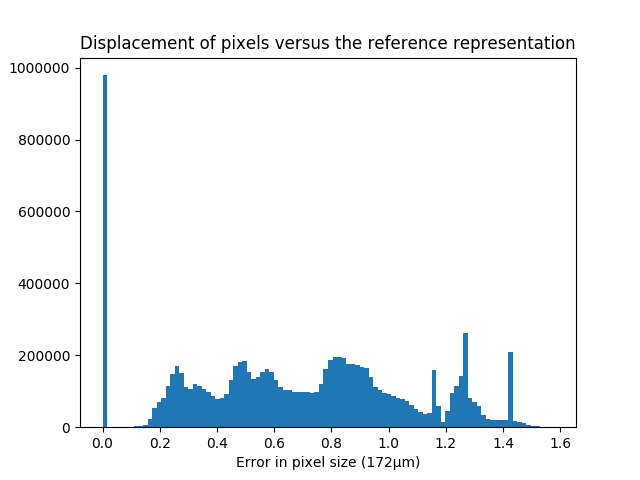

Text(0.5, 0, 'Error in pixel size (172µm)')

In [37]:
displ = numpy.sqrt(((pixel_coord - pixel_coord_raw)**2).sum(axis=-1))
displ /= pilatus.pixel1 #convert in pixel units
fig, ax = subplots()
ax.hist(displ.ravel(), 100)
ax.set_title("Displacement of pixels versus the reference representation")
ax.set_xlabel("Error in pixel size (172µm)")

In [38]:
unmasked = numpy.logical_not(all_masks)
misaligned = numpy.vstack((pixel_coord_raw[unmasked][..., 2].ravel(), #x
                           pixel_coord_raw[unmasked][..., 1].ravel())) #y

reference = numpy.vstack((pixel_coord[unmasked][..., 2].ravel(), #x
                          pixel_coord[unmasked][..., 1].ravel())) #y

def global_displacement(param):
    """correct all pixel position with dy. dx, angle"""
    dy, dx, angle = param
    rot = [[cos(angle), -sin(angle)],
           [sin(angle), cos(angle)]]
    trans = [[dx],
              [dy]]
    xy_corr = numpy.dot(rot, misaligned) + trans
    delta = xy_corr - reference
    return (delta*delta).sum()
global_displacement([0,0,0])

0.16861622856288666

In [39]:
%%time
guess_global = [0,0,0]
print("Before optimization", guess_global, "cost=", global_displacement(guess_global))
res_global = minimize(global_displacement, guess_global, method = "slsqp")
print(res_global)
print("After optimization", res_global.x, "cost=", global_displacement(res_global.x))

Before optimization [0, 0, 0] cost= 0.16861622856288666
     fun: 0.02783519916669572
     jac: array([ 0.24095988, -0.02946222, -0.02225194])
 message: 'Optimization terminated successfully.'
    nfev: 45
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([-1.16043934e-04, -2.56373233e-05,  5.33218327e-04])
After optimization [-1.16043934e-04 -2.56373233e-05  5.33218327e-04] cost= 0.02783519916669572
CPU times: user 5.44 s, sys: 2.67 s, total: 8.11 s
Wall time: 8.11 s


In [40]:
dy, dx, angle  = res_global.x
rot = [[cos(angle), -sin(angle)],
       [sin(angle), cos(angle)]]
trans = [[dx],
          [dy]]

raw = numpy.vstack((pixel_coord_raw[..., 2].ravel(), #x
                    pixel_coord_raw[..., 1].ravel())) #y
aligned = numpy.dot(rot, raw) + trans

pixel_coord_ref = pixel_coord.copy()
pixel_coord_ref[...,1] = aligned[1,:].reshape(pixel_coord_ref.shape[:-1])
pixel_coord_ref[...,2] = aligned[0,:].reshape(pixel_coord_ref.shape[:-1])


<IPython.core.display.Javascript object>


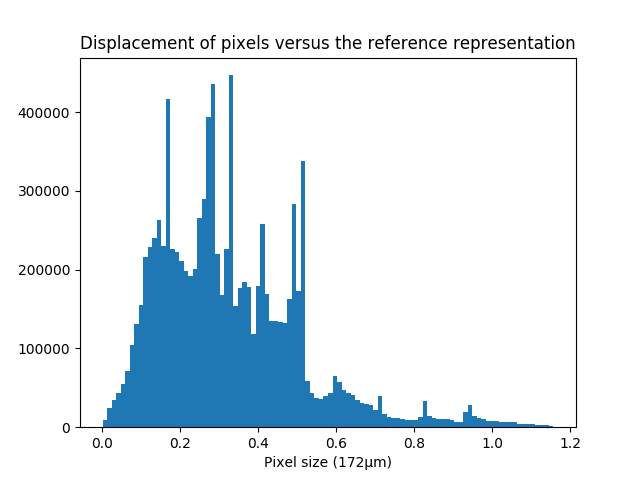

Text(0.5, 0, 'Pixel size (172µm)')

In [41]:
displ = numpy.sqrt(((pixel_coord-pixel_coord_ref)**2).sum(axis=-1))
displ /= pilatus.pixel1 #convert in pixel units
fig, ax = subplots()
ax.hist(displ.ravel(), 100)
ax.set_title("Displacement of pixels versus the reference representation")
ax.set_xlabel("Pixel size (172µm)")

In [42]:
pilatus.set_pixel_corners(pixel_coord_ref)
pilatus.mask = all_masks
pilatus.save("Pilatus_ID15_ref.h5")

## Conclusion

This tutorial presents the way to calibrate a module based detector using the Pilatus2M CdTe from ESRF-ID15.
The HDF5 file generated is directly useable by any parts of pyFAI, the reader is invited in calibrating the rings images with the default definition and with this optimized definition and check the residual error is almost divided by a factor two.

To come back on the precision of the localization of the pixel: not all the pixel are within the specifications provided by Dectris which claims the misaliment of the modules is within one pixel.

In [43]:
print("Total execution time: ", time.time()-start_time)

Total execution time:  80.33917880058289
